# Unmixing coercivity spectra from backfield curves

## Background on coercivity spectra

Natural samples contain ferromagnetic materials dispersed in paramagnetic and/or diamagnetic matrix material. Ferromagnetic mineral assemblages can be composed of minerals with different compositions, shapes, and sizes, such that they have different coercivities. Coercivity refers to the resistance of a ferromagnetic material to becoming demagnetized in the presence of an applied field. It is common in the fields of rock and environmental magnetism to use backfield magnetic remanence curves to gain insight into coercivity and thereby the ferromagnetic mineral assemblage within samples. Alternatively, a similar analysis can be conducted on isothermal remanent magnetization (IRM) acquisition or alternating field (AF) demagnetization data.

A backfield experiment is typically conducted on a vibrating sample magnetometer (VSM). In such an experiment, a strong external field is applied to the sample in one direction to induce a saturation isothermal remanent magnetization (sIRM), followed by the application of a field in the opposite direction. The process is repeated with the sIRM being applied, followed by reverse fields that are progressively larger in each step of the experiment. The derivative of the resultant backfield curve is referred to as the coercivity spectra. A common data analysis workflow is to fit components of this spectra to ‘unmix’ different populations of magnetic minerals.

Available programs for processing backfield coercivity curves include Max UnMix, IRM UnMix, GECA, IRM-CLG.

### Here is an example output of backfield unmixing results from Max UnMix (written in R):

This notebook largely follows the workflow of Max UnMix. We consider the total measured coercivity spectra as a sum of a number of skew-normal distributions. There is a difference between the method in this approach and that of Max UnMix in terms of uncertainty propagation. This programs utilizes the package `lmfit` which imbeds an uncertainty propagation procedure based on the covariance of the parameters of the fitted skew-normal distribution. Max UnMix program calculates uncertainty by bootstrapping the data.

<figure>
  <img src="https://raw.githubusercontent.com/PmagPy/RockmagPy-notebooks/main/book/images/MaxUnmix_example.png" alt="Description of the image" width="400">
</figure>

**MAX UnMix: A web application for unmixing magnetic coercivity distributions. DOI: http://dx.doi.org/10.1016/j.cageo.2016.07.009**

## Import scientific python libraries

Run the cell below to import the functions needed for the notebook.

In [1]:
import rockmag as rmag

import pmagpy.ipmag as ipmag
import pmagpy.contribution_builder as cb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import ipywidgets as widgets
from ipywidgets import interact, interactive, Layout, FloatSlider
from IPython.display import display, clear_output

from scipy.stats import skewnorm

from lmfit import Parameters, Model # for fitting
from lmfit.models import SkewedGaussianModel

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

pd.set_option('display.max_columns', 500)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Visualize a skewnormal distribution

We can visualize what a skewnormal distribution looks like. 

In [2]:
# Function to update the plot
def update_plot(location, scale, skewness):
    x = np.linspace(-10, 10, 1000)
    y = skewnorm.pdf(x, a=skewness, loc=location, scale=scale)
    plt.plot(x, y, label='Skew Normal Distribution')
    plt.title('Skew Normal Distribution')
    plt.xlabel('X')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create sliders for parameters
location_slider = FloatSlider(value=0, min=-10, max=10, step=0.1, description='Location');
scale_slider = FloatSlider(value=1, min=0.1, max=10, step=0.1, description='Scale');
skewness_slider = FloatSlider(value=0, min=-10, max=10, step=0.1, description='Skewness');

# Create interactive plot
interact(update_plot, location=location_slider, scale=scale_slider, skewness=skewness_slider);

interactive(children=(FloatSlider(value=0.0, description='Location', max=10.0, min=-10.0), FloatSlider(value=1…

## Import data

We can take the same approach as in the `rockmag_data_unpack.ipynb` notebook to bring the MagIC data into the notebook as a Contribution. To bring in a different contribution, set the directory path (currently `'./example_data/SSRM2022C'`) and the share key for your MagIC contribution which you can find by clicking on the "Share" button in the MagIC database.

<figure>
  <img src="book/images/MagIC_private_contribution_1.png" alt="Description of the image" width="800">
</figure>

copy the share key highlighted in grey in the following image to the `share_key` variable in the cell below.
<figure>
  <img src="book/images/MagIC_private_contribution_2.png" alt="Description of the image" width="800">
</figure>

**change the directory path and file name in the cell below to load your own data**


In [3]:
# define the path to the folder 
dir_path = 'example_data/SSRM2024C'
# download the data from the MagIC database using my private contribution key 
result, magic_file = ipmag.download_magic_from_id('20133', directory=dir_path, share_key='3b58527f-872b-4e64-a0f1-1e57120c9f15')
# unpack the MagIC file
ipmag.unpack_magic(magic_file, dir_path)
# get the contribution object
contribution = cb.Contribution(dir_path)
# get the measurements table
measurements = contribution.tables['measurements'].df
measurements.dropna(axis=1, how='all')

Download successful. File saved to: example_data/SSRM2024C/magic_contribution_20133.txt
working on:  'contribution'
1  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/contribution.txt
contribution  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/contribution.txt
working on:  'locations'
1  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/locations.txt
locations  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/locations.txt
working on:  'sites'
16  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/sites.txt
sites  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/sites.txt
working on:  'samples'
28  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/samples.txt
samples  data put in  /Users/yimingzhang/Github/Rockm

,dir_dec,dir_inc,experiment,instrument_codes,magn_mass,magn_moment,magn_r2_det,magn_x,magn_y,magn_z,meas_field_ac,meas_field_dc,meas_freq,meas_pos_z,meas_temp,measurement,method_codes,quality,sequence,software_packages,specimen,standard,susc_chi_mass,susc_chi_qdr_mass,timestamp,treat_ac_field,treat_dc_field
measurement name,,,,,,,,,,,,,,,,,,,,,,,,,,,
IRM-Magnon-14466-0,NaN,NaN,IRM-Magnon-LP-X:LP-X-F:LP-X-H-14466,IRM-Magnon,NaN,NaN,NaN,NaN,NaN,NaN,0.000377,NaN,31.0,NaN,293.0,IRM-Magnon-14466-0,LP-X:LP-X-F:LP-X-H,g,NaN,IRMDB Version2,MA1-1b,u,0.001594,0.000006,2024:06:05:15:51:58.00,NaN,NaN
IRM-Magnon-14466-1,NaN,NaN,IRM-Magnon-LP-X:LP-X-F:LP-X-H-14466,IRM-Magnon,NaN,NaN,NaN,NaN,NaN,NaN,0.000377,NaN,305.0,NaN,293.0,IRM-Magnon-14466-1,LP-X:LP-X-F:LP-X-H,g,NaN,IRMDB Version2,MA1-1b,u,0.001610,0.000006,2024:06:05:15:51:58.00,NaN,NaN
IRM-Magnon-14466-2,NaN,NaN,IRM-Magnon-LP-X:LP-X-F:LP-X-H-14466,IRM-Magnon,NaN,NaN,NaN,NaN,NaN,NaN,0.000377,NaN,1030.0,NaN,293.0,IRM-Magnon-14466-2,LP-X:LP-X-F:LP-X-H,g,NaN,IRMDB Version2,MA1-1b,u,0.001605,0.000014,2024:06:05:15:51:58.00,NaN,NaN
IRM-Magnon-14466-3,NaN,NaN,IRM-Magnon-LP-X:LP-X-F:LP-X-H-14466,IRM-Magnon,NaN,NaN,NaN,NaN,NaN,NaN,0.000151,NaN,1030.0,NaN,293.0,IRM-Magnon-14466-3,LP-X:LP-X-F:LP-X-H,g,NaN,IRMDB Version2,MA1-1b,u,0.001600,0.000012,2024:06:05:15:51:58.00,NaN,NaN
IRM-Magnon-14466-4,NaN,NaN,IRM-Magnon-LP-X:LP-X-F:LP-X-H-14466,IRM-Magnon,NaN,NaN,NaN,NaN,NaN,NaN,0.000050,NaN,1030.0,NaN,293.0,IRM-Magnon-14466-4,LP-X:LP-X-F:LP-X-H,g,NaN,IRMDB Version2,MA1-1b,u,0.001590,0.000010,2024:06:05:15:51:58.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nan,38.182488,23.926673,"SJ1-5b-NRM_demag(T,Hac)-LP-DIR-AF-0",IRM-SRM-U,NaN,5.942540e-08,NaN,4.269700e-08,3.357810e-08,2.410100e-08,NaN,NaN,NaN,0.45,NaN,None,LP-DIR-AF,None,NaN,None,SJ1-5b,None,NaN,NaN,2024:06:05:09:35:29.00,0.17,NaN
nan,-194.492598,-32.183836,"MA1-1b-NRM_demag(T,Hac)-LP-DIR-AF-0",IRM-SRM-U,NaN,2.107890e-06,NaN,-1.727230e-06,4.464540e-07,-1.122740e-06,NaN,NaN,NaN,0.65,NaN,None,LP-DIR-AF,None,NaN,None,MA1-1b,None,NaN,NaN,2024:06:05:09:35:51.00,0.17,NaN
nan,-215.249814,-18.923425,"MA1-2b-NRM_demag(T,Hac)-LP-DIR-AF-0",IRM-SRM-U,NaN,8.466490e-07,NaN,-6.540420e-07,4.622280e-07,-2.745720e-07,NaN,NaN,NaN,0.85,NaN,None,LP-DIR-AF,None,NaN,None,MA1-2b,None,NaN,NaN,2024:06:05:09:36:13.00,0.17,NaN


In [4]:
measurements.method_codes.unique()

array(['LP-X:LP-X-F:LP-X-H', 'LP-X:LP-X-T:LP-X-F', 'LP-X-T', 'LP-HYS',
       'LP-BCR-BF', 'LP-FC', 'LP-ZFC', 'LP-CW-SIRM:LP-MC',
       'LP-CW-SIRM:LP-MW', 'LP-DIR-AF'], dtype=object)

## now let's extract the backfield experiment data (LP-BCR-BF) from the measurements table

- the previous cell shows that there are two types of experiments for this specimen
- let's filter for the experiment with a protocol of `LP-BCR-BF` which stands for lab protocol-backfield coercivity remanence-backfield

- columns `magn_mass` and `treat_dc_field` contain the magnetization (mass normalized) and the applied back field respectively.
- they are what we need for coercivity unmixing

In [5]:
# filter for backfield measurements
backfield_measurements = measurements[measurements.method_codes == 'LP-BCR-BF']
# let's drop the empty columns
backfield_measurements = backfield_measurements.dropna(axis=1, how='all')
# let's inspec the data table
backfield_measurements.head()

,experiment,instrument_codes,magn_mass,measurement,method_codes,quality,specimen,standard,timestamp,treat_dc_field
measurement name,,,,,,,,,,
MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393701,IRM-VSM3-LP-BCR-BF-239370,IRM-VSM3,0.002470,MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393701,LP-BCR-BF,g,MA1-5-r gelcap,300,2024:06:06:15:41:00.00,-0.000070
MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393702,IRM-VSM3-LP-BCR-BF-239370,IRM-VSM3,0.001872,MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393702,LP-BCR-BF,g,MA1-5-r gelcap,300,2024:06:06:15:41:00.00,-0.005054
MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393703,IRM-VSM3-LP-BCR-BF-239370,IRM-VSM3,0.001353,MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393703,LP-BCR-BF,g,MA1-5-r gelcap,300,2024:06:06:15:41:00.00,-0.010090
MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393704,IRM-VSM3-LP-BCR-BF-239370,IRM-VSM3,0.000952,MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393704,LP-BCR-BF,g,MA1-5-r gelcap,300,2024:06:06:15:41:00.00,-0.015070
MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393705,IRM-VSM3-LP-BCR-BF-239370,IRM-VSM3,0.000591,MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393705,LP-BCR-BF,g,MA1-5-r gelcap,300,2024:06:06:15:41:00.00,-0.020050


## Now let's select a specimen and its X-T experiment of interest

- One could do multiple rounds of X-T experiments on the same specimen
- so choose in the `first dropdown menu` the specimen of interest
- the choose in the `second dropdown menu` the experiment of interest

In [6]:
specimen, experiment = rmag.interactive_specimen_experiment_selection(backfield_measurements)

Dropdown(description='specimen:', options=('MA1-5-r gelcap', 'MA1-OX-r', 'SJ1-4-r gelcap', 'SJ5-5-r gelcap', '…

Dropdown(description='Experiment:', options=('IRM-VSM3-LP-BCR-BF-239370',), value='IRM-VSM3-LP-BCR-BF-239370')

### We need to do some preprocessing on the raw data in order to unmix the spectrum

pick your own `smooth_frac` value between 0 and 1 for smoothing the raw backfield data

## Example 1

In [7]:
specimne_1 = 'SJ1-4-r gelcap'
experiment_1 = 'IRM-VSM4-LP-BCR-BF-239364'
smooth_frac = 0.0

selected_experiment = backfield_measurements[(backfield_measurements['specimen']==specimne_1) & 
                                      (backfield_measurements['experiment']==experiment_1)].reset_index(drop=1)
selected_experiment = rmag.backfield_data_processing(selected_experiment, smooth_frac=smooth_frac)

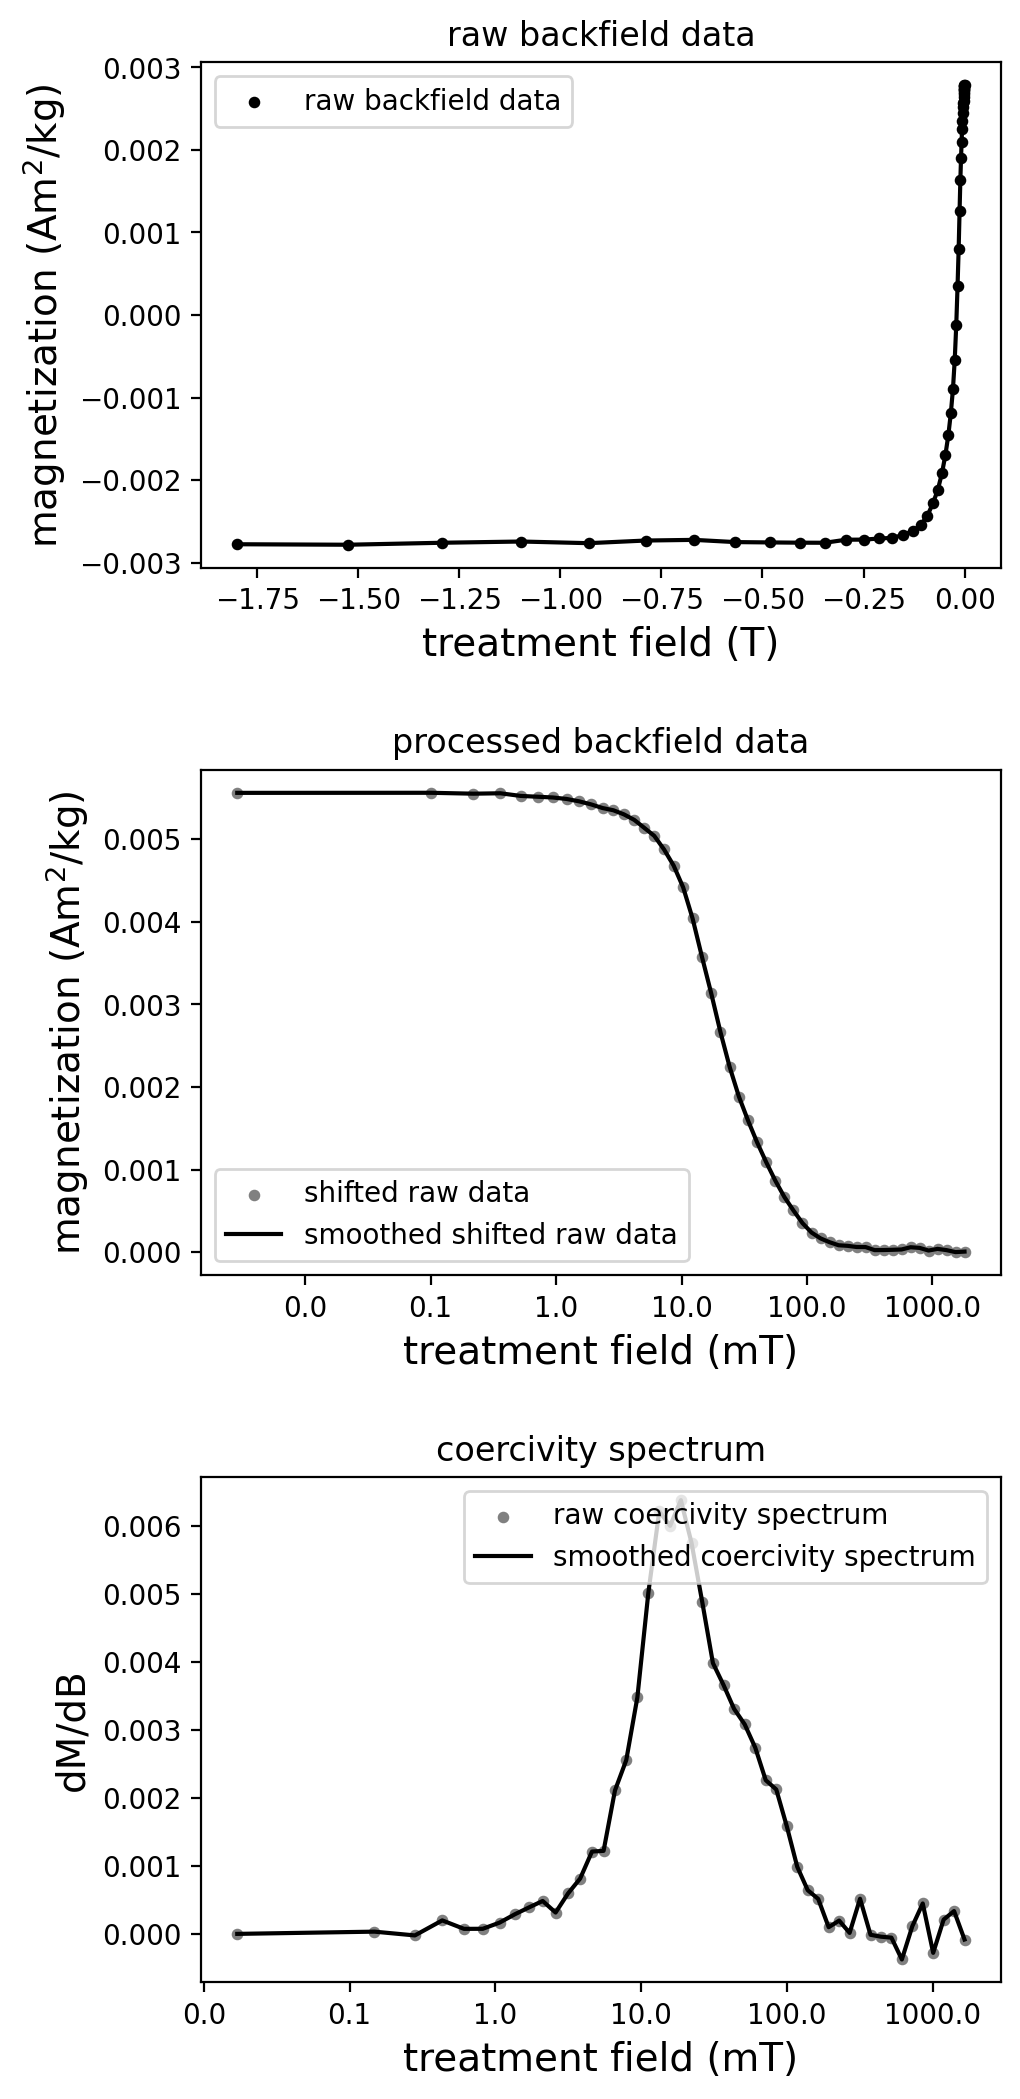

In [8]:
fig, (ax1, ax2, ax3) = rmag.plot_backfield_data(selected_experiment)

## Now let's do the unmixing

### set up initial guesses for skewnormal distribution parameters

- you need to set up your own Pandas DataFrame table for the initial guesses of the skewnormal distribution parameters
- the parameter table gets updated each time you run the unmixing algorithm

In [9]:
parameters = pd.DataFrame({'amplitude': [0.006], 'center': [9], 'sigma': [10.0], 'gamma': [0]})
parameters

,amplitude,center,sigma,gamma
0,0.006,9,10.0,0


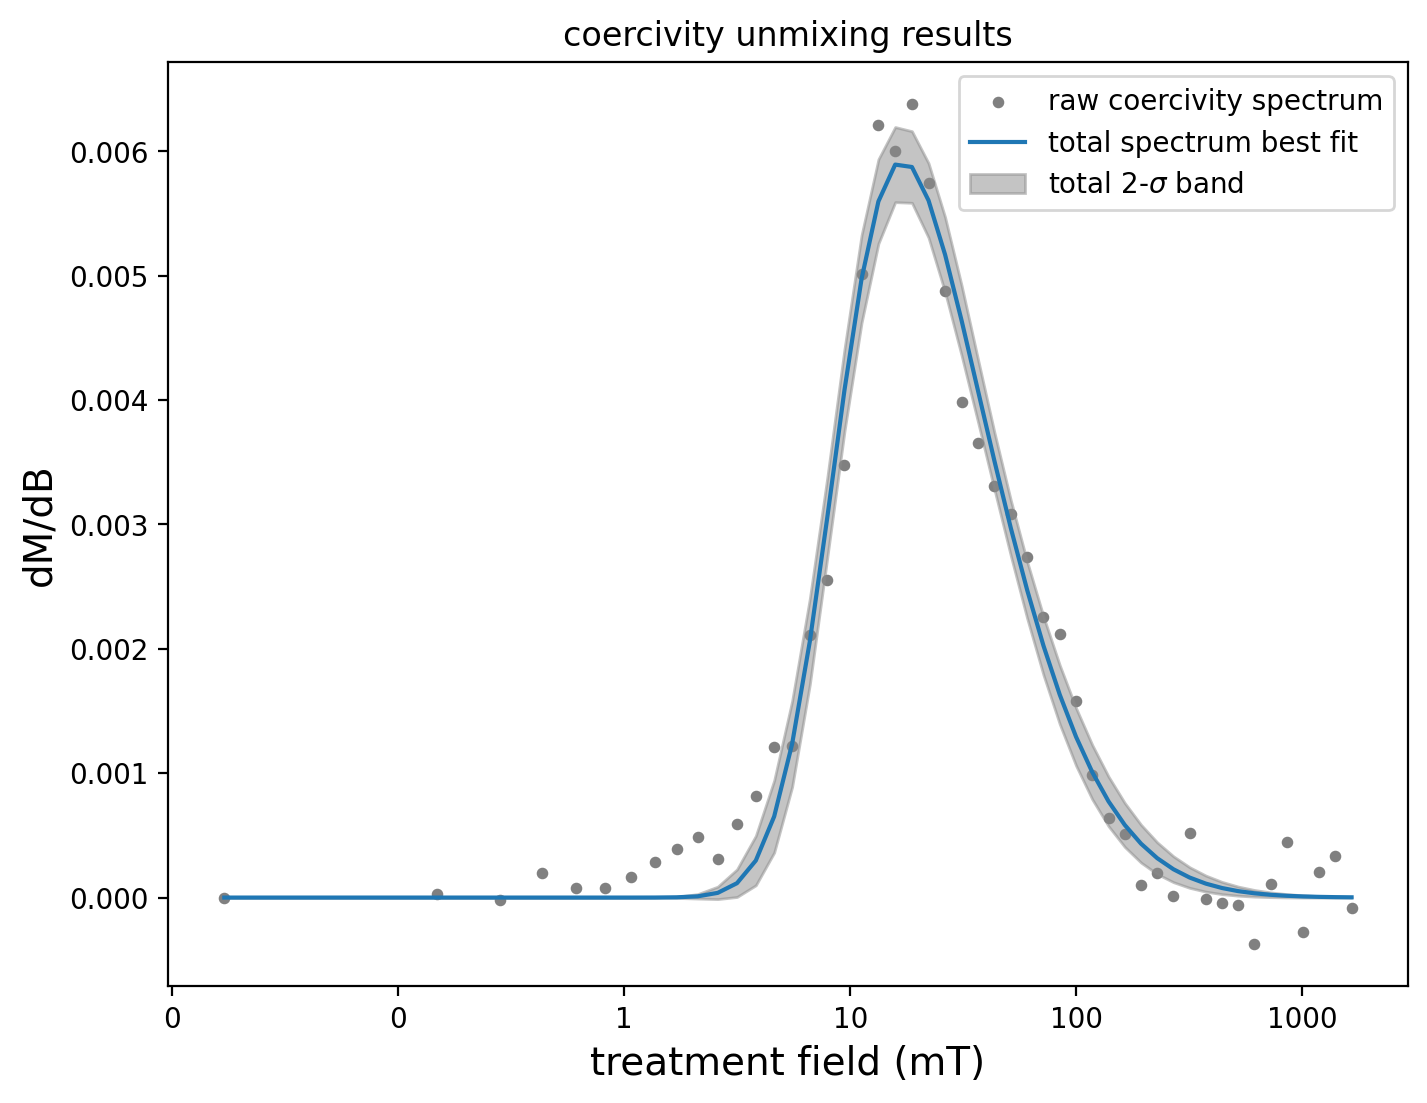

In [10]:
result, updated_parameters = rmag.backfield_unmixing(selected_experiment, n_comps=1, parameters=parameters)
fig, ax = rmag.plot_backfield_unmixing_result(selected_experiment, result)

## Example 2

- we can also try to fit this data with two components

In [11]:
parameters = pd.DataFrame({'amplitude': [0.006, 0.002], 'center': [9, 50], 'sigma': [10.0, 10], 'gamma': [0, 0]})
parameters

,amplitude,center,sigma,gamma
0,0.006,9,10.0,0
1,0.002,50,10.0,0


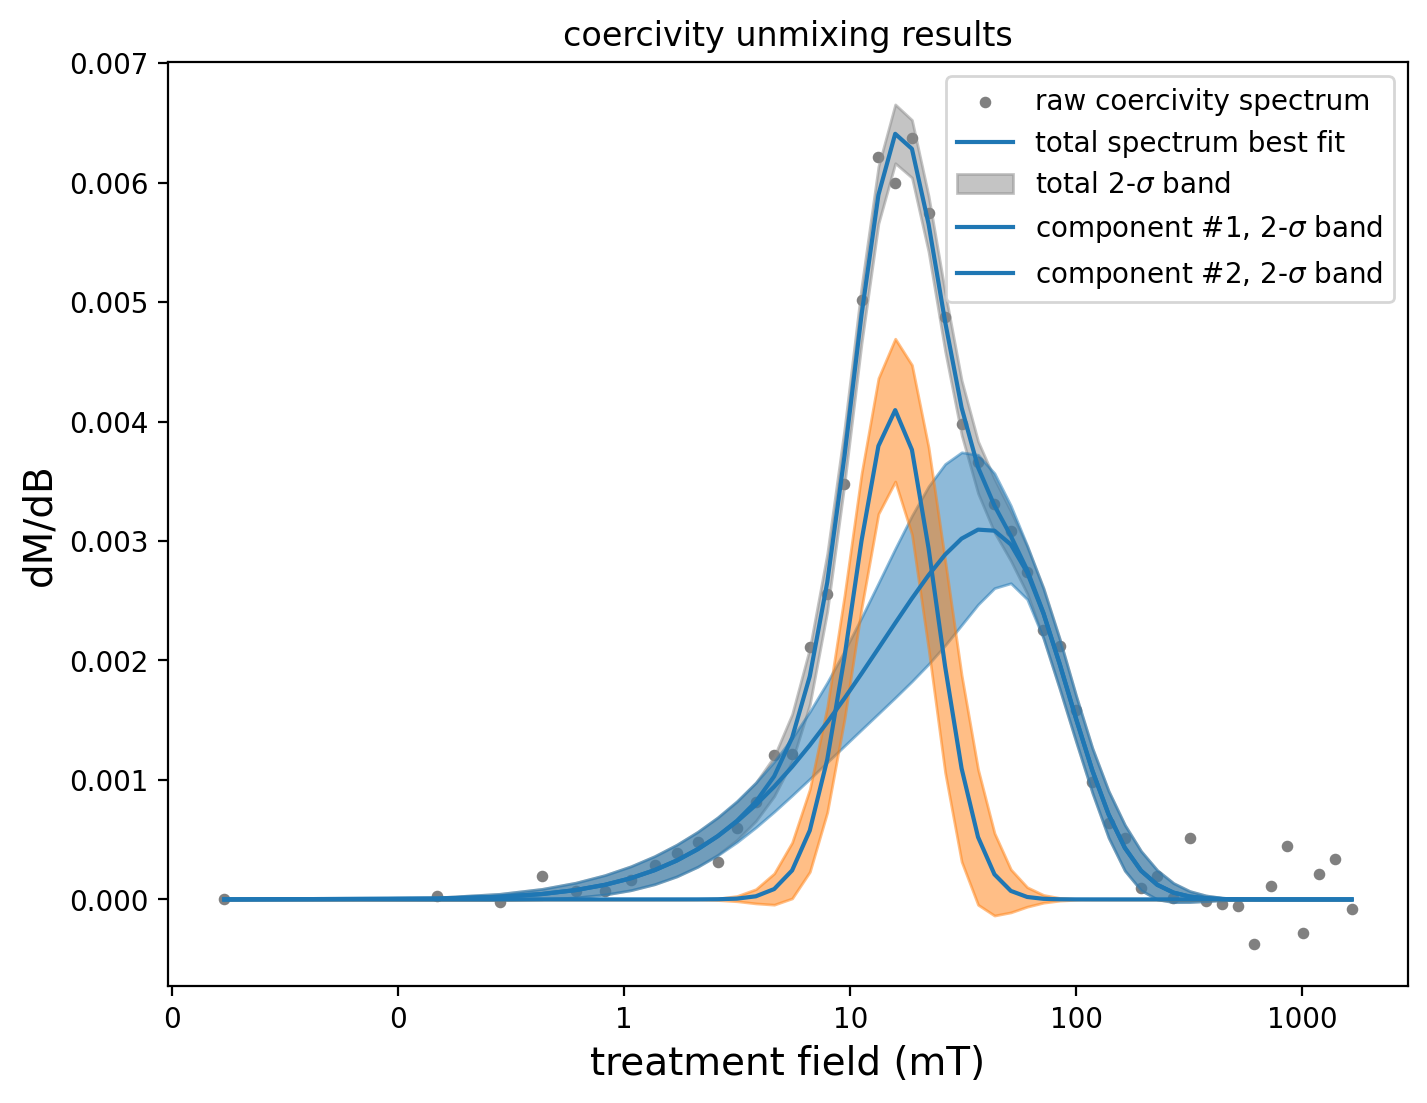

In [12]:
result, updated_parameters = rmag.backfield_unmixing(selected_experiment, n_comps=2, parameters=parameters)
fig, ax = rmag.plot_backfield_unmixing_result(selected_experiment, result)

## Example 3

In [13]:
specimne_2 = 'MA1-OX-r'
experiment_2 = 'IRM-VSM4-LP-BCR-BF-239379'
smooth_frac = 0.03

selected_experiment = backfield_measurements[(backfield_measurements['specimen']==specimne_2) & 
                                      (backfield_measurements['experiment']==experiment_2)].reset_index(drop=1)
selected_experiment = rmag.backfield_data_processing(selected_experiment, smooth_frac=smooth_frac)

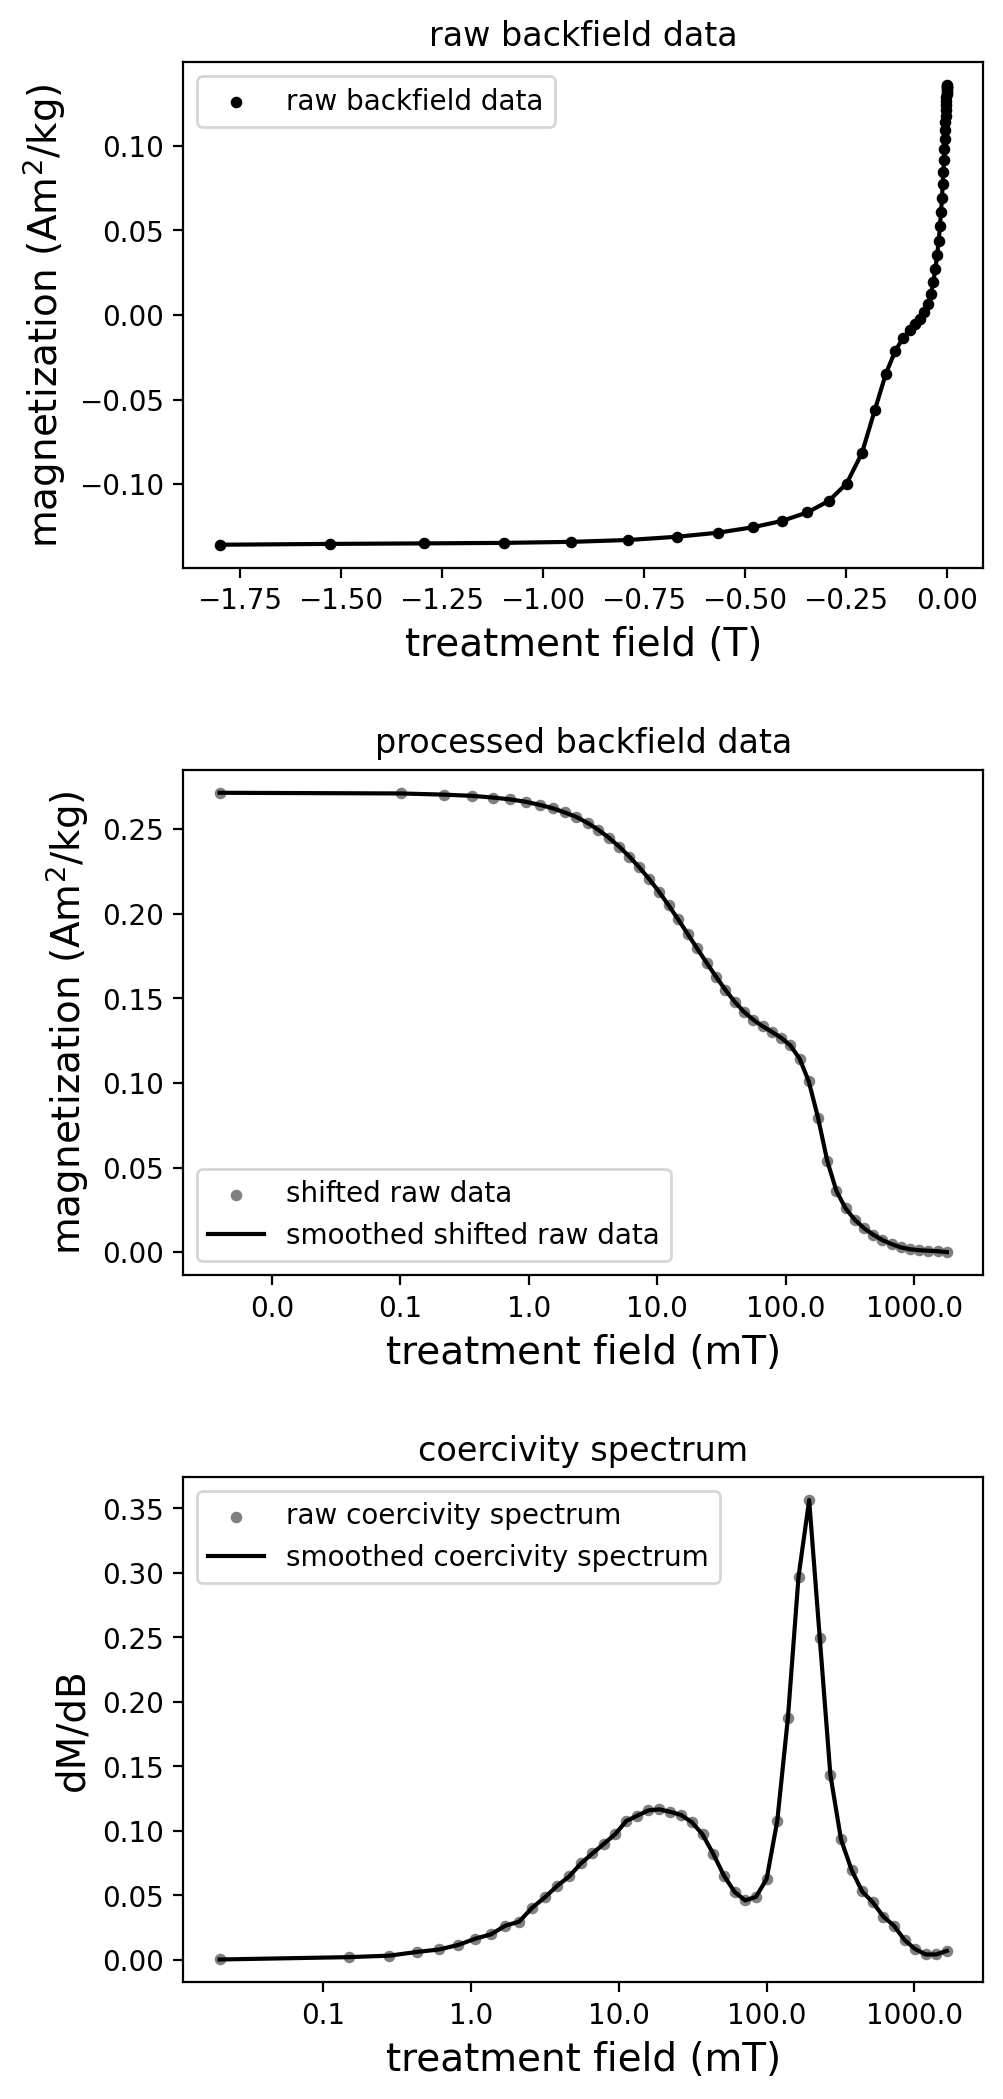

In [14]:
fig, (ax1, ax2, ax3) = rmag.plot_backfield_data(selected_experiment)

## Now let's do the unmixing

### set up initial guesses for skewnormal distribution parameters

- you need to set up your own Pandas DataFrame table for the initial guesses of the skewnormal distribution parameters
- the parameter table gets updated each time you run the unmixing algorithm

In [15]:
parameters = pd.DataFrame({'amplitude': [0.1, 0.35, 0.1], 'center': [10, 100, 1000], 'sigma': [3, 10, 50], 'gamma': [0, 0, 0]})
parameters

,amplitude,center,sigma,gamma
0,0.10,10,3,0
1,0.35,100,10,0
2,0.10,1000,50,0


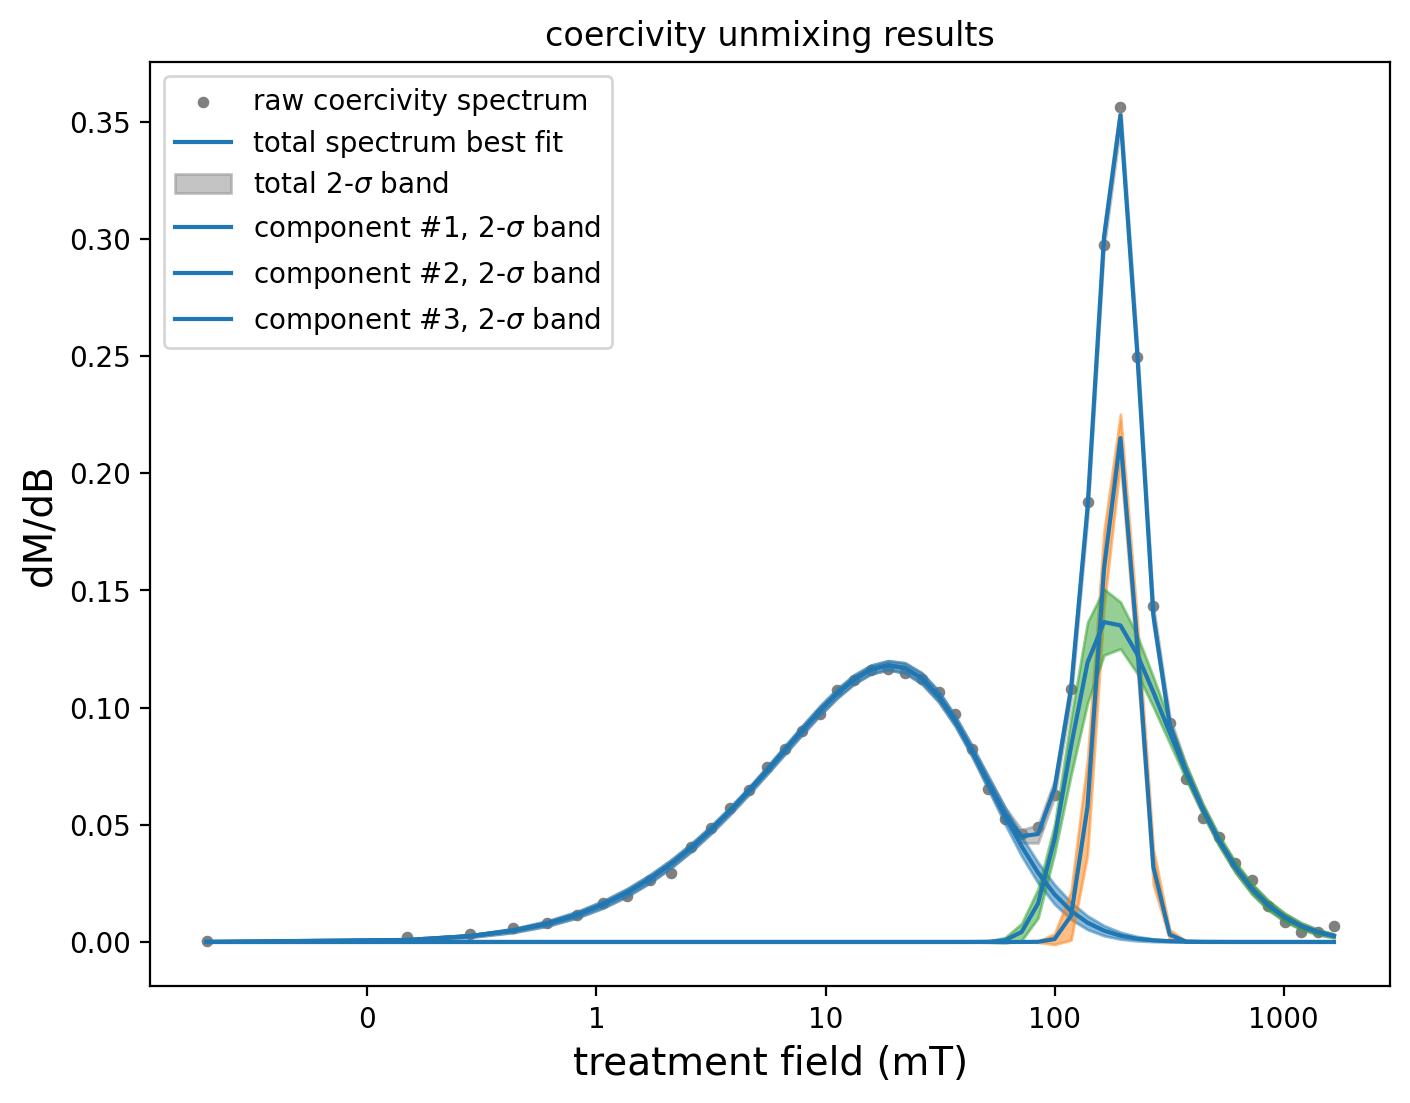

In [16]:
result, updated_parameters = rmag.backfield_unmixing(selected_experiment, n_comps=3, parameters=parameters)
fig, ax = rmag.plot_backfield_unmixing_result(selected_experiment, result)

## Save the plot

Put the name of the file in the cell below. There are many available file formats for figures such as: `jpg`, `pdf`, `png`. Whatever you choose in the file name will be the file type.

Set the `save_directory`. If you want it to be the folder that the notebook is in, set it to be `'.'`.

In [17]:
file_name = 'output.png'
save_directory = './example_data/SSRM2024C' 

file_path = save_directory + '/' + file_name
# fig.savefig(file_path, dpi=300)